# Introduction to LSTM

LSTM (Long Short-Term Memory) networks are designed to work with sequential data, like time series, where previous data points affect future ones.

They belong to the Recurrent Neural Network (RNN) family but have an advantage over traditional RNNs because of their ability to remember information over long sequences.

Key Components:

* Cell State: A memory unit that stores long-term information.
* Gates:
    * Forget Gate: Decides which information to throw away.
    * Input Gate: Determines which new information is important.
    * Output Gate: Controls the output based on the cell state.

By using gates, LSTMs can handle long-range dependencies, making them powerful for time-series prediction tasks, such as maintenance prediction where trends and cycles affect future outcomes.



## LSTM is good for:

In maintenance prediction:

* Sequential data: 

Could be sensor readings, operational data, or environmental conditions logged over time.

* Goal: 

Predict future failure points, based on historical data, so that preventive actions can be taken.

* Some examples of features in predictive maintenance:
    * Vibration data: Indicates mechanical wear.
    * Temperature readings: Changes could point to overheating.
    * Current usage: Anomalies in energy consumption could signal a problem.

# Data

A generated dataset with `10 sensor `readings over time, along with a column indicating the state of a machine (`normal, broken, recovery`). The sensor readings reflect different behaviors depending on the machine's state:

* `Normal state`: Sensors behave with low variance.
* `Broken state`: Sensors display abnormal, more extreme values.
* `Recovery state`: Sensors gradually return to normal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-01-01', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 500 + ['broken'] * 200 + ['recovery'] * 300

for i in range(500, 700):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
for i in range(700, 1000):  # Recovery state: return to normal
    sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df['state'] = state_labels

df.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state
2023-01-01 00:00:00,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,normal
2023-01-01 01:00:00,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,normal
2023-01-01 02:00:00,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,normal
2023-01-01 03:00:00,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,normal
2023-01-01 04:00:00,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,normal


In [2]:
def calculate_class_percentage(series):

    class_counts = series.value_counts()
    class_percentage = (class_counts / len(series)) * 100
    class_percentage_df = pd.DataFrame(class_percentage)
    
    return class_percentage_df

In [3]:
calculate_class_percentage(df.state)

,state
normal,50.0
recovery,30.0
broken,20.0


In [7]:
def plot_time_series_with_marker(data, columns_to_plot, marker_column, marker_value):

    if not pd.api.types.is_datetime64_any_dtype(data.index):
        raise ValueError("The index of the DataFrame must be datetime-like.")
    missing_cols = [col for col in columns_to_plot if col not in data.columns]
    if marker_column not in data.columns:
        missing_cols.append(marker_column)
    
    if missing_cols:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_cols}")
    

    num_plots = len(columns_to_plot)
    num_rows = (num_plots + 2) // 1
    
    fig, axes = plt.subplots(num_rows, 1, figsize=(15, 2 * num_rows))
    axes = axes.flatten()
    
    for i, column in enumerate(columns_to_plot):
        sns.lineplot(data=data, x=data.index, y=data[column], ax=axes[i], label=column, color='black')
        
        # Mark the broken
        marked_points = data[data[marker_column] == marker_value]
        if not marked_points.empty:
            axes[i].scatter(marked_points.index, marked_points[column], color='red',marker='x', label=f'{marker_column} = BROKEN')
        
        axes[i].set_title(f'{column} vs Time')
        axes[i].legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

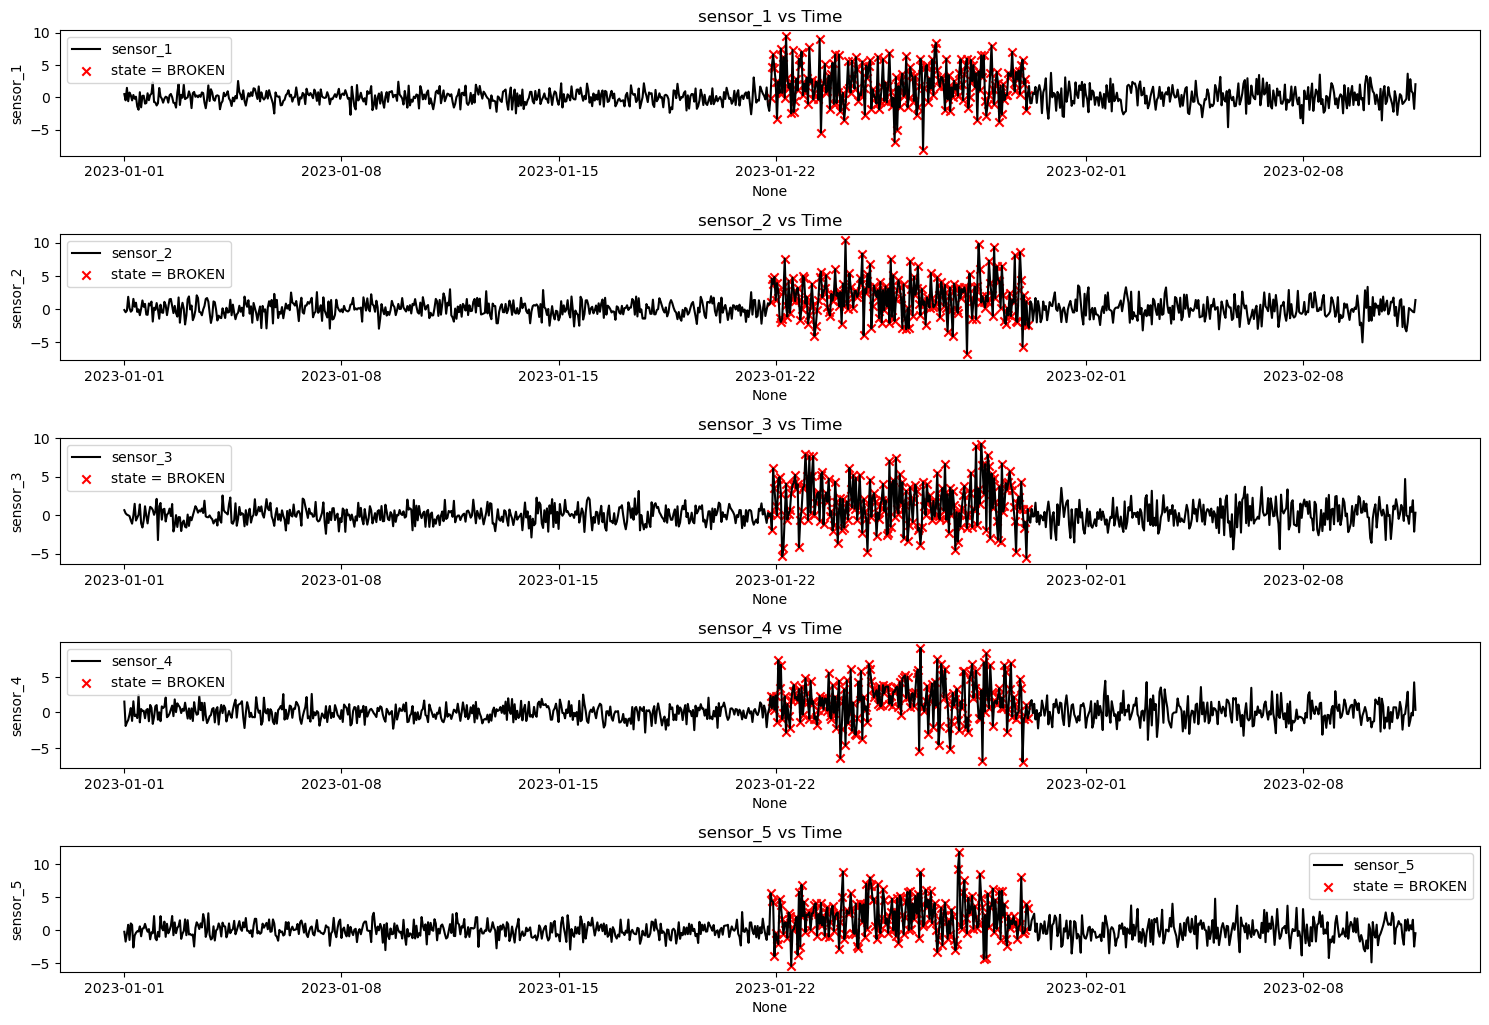

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_time_series_with_marker(df, ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5'],'state','broken')

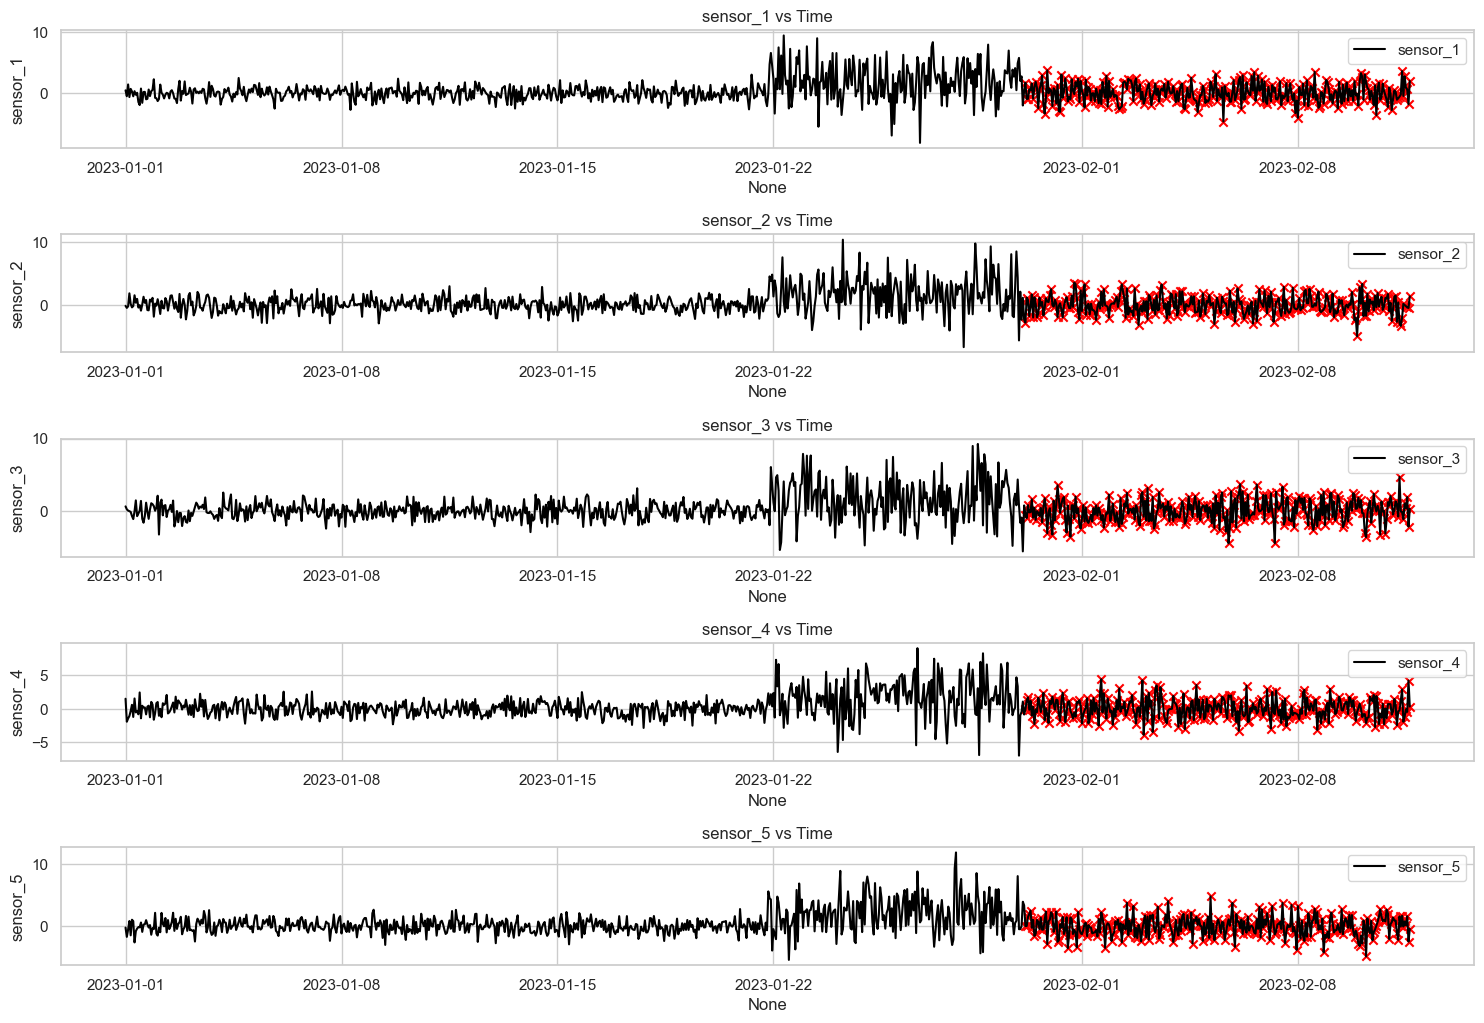

In [996]:
plot_time_series_with_marker(df, ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5'],'state','recovery')

# Data preprocessing

## Missing values
In time series data, it's common to encounter missing values (gaps). Since LSTM models require continuous sequences, missing values must be dealt with before training. For now, our dataset does not have any missing values.

* Filling missing values (using methods like forward fill, backward fill, or interpolation).

In [9]:
df = df.interpolate(method='linear')  # Interpolate

## Feature Scaling

LSTMs are sensitive to the scale of the input data.

Typically, time-series data needs to be normalized or scaled so that all features lie within the same range. 

This helps the model learn effectively and prevents dominance of features with larger numeric ranges.
* LSTM optimizes better with scaled inputs, and unscaled data can slow down or prevent convergence.

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Scale only the sensor data !
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sensor_data = scaler.fit_transform(df.iloc[:, :-1])

## Encoding the Categorical State Column

The state column contains the labels normal, broken, and recovery, which are categorical. 

We will need to convert these labels into numeric values that the LSTM model can process.

There are a few common encoding methods:

* `One-hot encoding`: Transforms the categorical labels into binary vectors.
* `Label encoding`: Converts each state into an integer.

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['state_encoded'] = label_encoder.fit_transform(df['state'])

## Creating Sequences

LSTM models expect input data in sequences.

For time-series data, this means dividing the sensor data into windows (`sliding windows`) of a fixed length.

Each sequence will contain multiple timesteps of sensor readings, which the LSTM will use to predict the machine’s state or future sensor readings.
___
A result is a 3D array where each element is a sequence of sensor readings over time (shape: [#sequences, seq_length, #sensors]).

If we also want to predict the machine state at each step, we’ll need to align the target values with the input sequences:

In [182]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

seq_length = 100  # sequence length
X = create_sequences(scaled_sensor_data, seq_length)

In [184]:
y = df['state_encoded'].values[seq_length:]  # Align labels

## Train-Test Split

Before training, we’ll divide the data into training and testing sets. This allows us to train the model on one part of the data and validate its performance on unseen data.

In [186]:
# 80% training
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [188]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((720, 100, 10), (180, 100, 10), (720,), (180,))

# Building the LSTM Model

The model will take sequences of sensor data as input and output the predicted machine state.

**LSTM Model Architecture:**

* LSTM Layers: These layers will capture patterns from sequences of sensor data (the temporal dependencies in the sensor data.).
* Dense Layer: The final fully connected layer will output the predicted state (adds complexity and helps the model learn non-linear combinations of features).
* Activation Function: We will use softmax in the final layer since this is a multi-class classification problem (predicting 3 states: normal, broken, recovery).

In [198]:
from keras.models import Sequential
from keras import layers


model = Sequential([
    # LSTM layer with 50 units, return sequences for further LSTM layers
    layers.LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    # layers.LSTM(50, return_sequences=False),
    layers.Dropout(0.5),
    layers.Dense(25, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') # 3 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 100)               44400     
                                                                 
 dropout_25 (Dropout)        (None, 100)               0         
                                                                 
 dense_42 (Dense)            (None, 25)                2525      
                                                                 
 dropout_26 (Dropout)        (None, 25)                0         
                                                                 
 dense_43 (Dense)            (None, 3)                 78        
                                                                 
Total params: 47003 (183.61 KB)
Trainable params: 47003 (183.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [200]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df['state_encoded']), y=df['state_encoded'])
class_weights = dict(enumerate(class_weights))

# Display the calculated class weights
class_weights

{0: 1.6666666666666667, 1: 0.6666666666666666, 2: 1.1111111111111112}

## Training the Model

Epoch 1/20
180/180 [==============================] - 10s 45ms/step - loss: 1.0844 - accuracy: 0.3222 - val_loss: 1.4110 - val_accuracy: 0.0000e+00
Epoch 2/20
180/180 [==============================] - 8s 44ms/step - loss: 0.9833 - accuracy: 0.4625 - val_loss: 1.5432 - val_accuracy: 0.0000e+00
Epoch 3/20
180/180 [==============================] - 7s 41ms/step - loss: 0.9297 - accuracy: 0.6222 - val_loss: 1.2413 - val_accuracy: 0.0000e+00
Epoch 4/20
180/180 [==============================] - 7s 40ms/step - loss: 1.0140 - accuracy: 0.4542 - val_loss: 1.3137 - val_accuracy: 0.0000e+00
Epoch 5/20
180/180 [==============================] - 11s 64ms/step - loss: 0.7917 - accuracy: 0.6819 - val_loss: 1.3745 - val_accuracy: 0.0000e+00
Epoch 6/20
180/180 [==============================] - 8s 43ms/step - loss: 0.9355 - accuracy: 0.6042 - val_loss: 1.3181 - val_accuracy: 0.0000e+00
Epoch 7/20
180/180 [==============================] - 7s 40ms/step - loss: 0.6102 - accuracy: 0.7972 - val_loss: 1.3

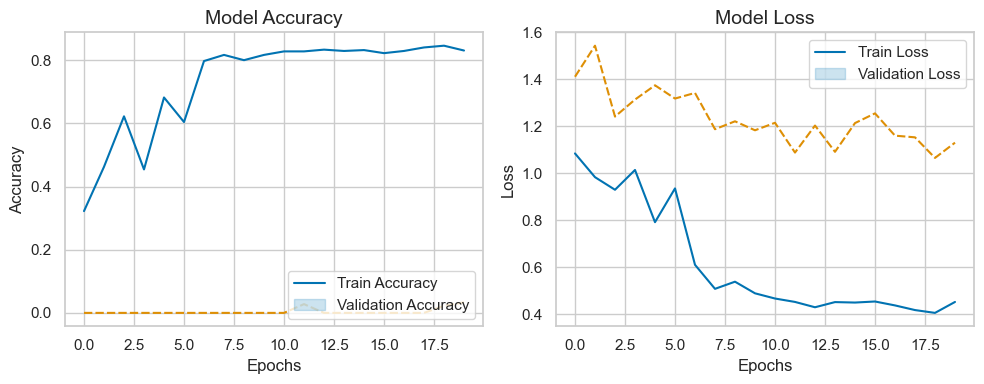

6/6 [==============================] - 2s 68ms/step - loss: 1.1302 - accuracy: 0.0333
Test Loss: 1.1302299499511719, Test Accuracy: 0.03333333507180214


In [202]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=4, class_weight=class_weights)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

## Let’s proceed with building an LSTM Autoencoder for anomaly detection

In [216]:
df

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state,state_encoded
2023-01-01 00:00:00,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,normal,1
2023-01-01 01:00:00,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,normal,1
2023-01-01 02:00:00,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,normal,1
2023-01-01 03:00:00,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,normal,1
2023-01-01 04:00:00,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11 11:00:00,2.802049,-0.005869,1.050746,-1.131907,0.754634,0.412640,-0.084759,-0.752637,-0.957045,0.423529,recovery,2
2023-02-11 12:00:00,0.943409,-0.190744,0.430902,-0.056872,0.147789,-0.300667,0.026959,4.047061,0.467451,0.967945,recovery,2
2023-02-11 13:00:00,0.657035,-0.394225,1.940984,-0.436746,1.582582,-0.501310,-1.439959,0.548094,-1.657003,0.803460,recovery,2
2023-02-11 14:00:00,-1.791238,-0.478512,-2.147595,4.236251,-2.480939,0.014721,1.714956,1.554579,1.277013,-0.475843,recovery,2


In [595]:
# Filter out only normal state data for training
normal_data = df.drop('state',axis=1)[df['state_encoded'] == 1].iloc[:, :-1].values  # Only use sensor data, excluding the state column

# Scale the normal data
scaler = MinMaxScaler()
normal_data_scaled = scaler.fit_transform(normal_data)

# Create sequences for the LSTM autoencoder
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

seq_length = 1  # Sequence length can be adjusted
X_train = create_sequences(normal_data_scaled, seq_length)

## Build the LSTM Autoencoder Model

We will now create the LSTM Autoencoder. This model will try to reconstruct the input sequences (sensor readings), and large reconstruction errors will indicate potential anomalies.

* Encoder: This part learns to compress the data.
* Decoder: This part reconstructs the data from the compressed form.

In [763]:
model = Sequential([
    
    layers.LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    layers.LSTM(40, return_sequences=True,activation='relu'),
    layers.LSTM(40, return_sequences=True,activation='relu'),
    # layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.LSTM(80, return_sequences=True,activation='relu'),
    layers.BatchNormalization(),
    layers.LSTM(160, return_sequences=True,activation='relu'),
    layers.BatchNormalization(),
    layers.LSTM(160, return_sequences=True,activation='relu'),
    layers.BatchNormalization(),
    layers.LSTM(320, return_sequences=True,activation='relu'),
    layers.LSTM(640, return_sequences=False,activation='relu'),
    layers.Dropout(0.1),
    
    layers.RepeatVector(X_train.shape[1]),
    # layers.LSTM(320, activation='relu', return_sequences=True),
    # layers.Dropout(0.2),
    layers.LSTM(100, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(X_train.shape[2]))
])

model.compile(optimizer='adamax', loss='mse')  # Mean Squared Error loss for reconstruction
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_238 (LSTM)             (None, 1, 20)             2480      
                                                                 
 lstm_239 (LSTM)             (None, 1, 40)             9760      
                                                                 
 lstm_240 (LSTM)             (None, 1, 40)             12960     
                                                                 
 batch_normalization_67 (Ba  (None, 1, 40)             160       
 tchNormalization)                                               
                                                                 
 lstm_241 (LSTM)             (None, 1, 80)             38720     
                                                                 
 batch_normalization_68 (Ba  (None, 1, 80)             320       
 tchNormalization)                                   

## Train the Model

In [765]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=8)
history = model.fit(X_train, X_train, epochs=500, batch_size=100, validation_split=0.2, callbacks=early_stop)

Epoch 1/500
4/4 [==============================] - 62s 2s/step - loss: 0.2628 - val_loss: 0.2474
Epoch 2/500
4/4 [==============================] - 1s 347ms/step - loss: 0.2518 - val_loss: 0.2405
Epoch 3/500
4/4 [==============================] - 1s 364ms/step - loss: 0.2291 - val_loss: 0.2324
Epoch 4/500
4/4 [==============================] - 1s 349ms/step - loss: 0.1793 - val_loss: 0.2229
Epoch 5/500
4/4 [==============================] - 1s 343ms/step - loss: 0.1379 - val_loss: 0.2141
Epoch 6/500
4/4 [==============================] - 1s 356ms/step - loss: 0.0849 - val_loss: 0.2071
Epoch 7/500
4/4 [==============================] - 1s 362ms/step - loss: 0.0482 - val_loss: 0.1991
Epoch 8/500
4/4 [==============================] - 1s 354ms/step - loss: 0.0348 - val_loss: 0.1934
Epoch 9/500
4/4 [==============================] - 1s 351ms/step - loss: 0.0289 - val_loss: 0.1907
Epoch 10/500
4/4 [==============================] - 1s 340ms/step - loss: 0.0261 - val_loss: 0.1875
Epoch 11/50

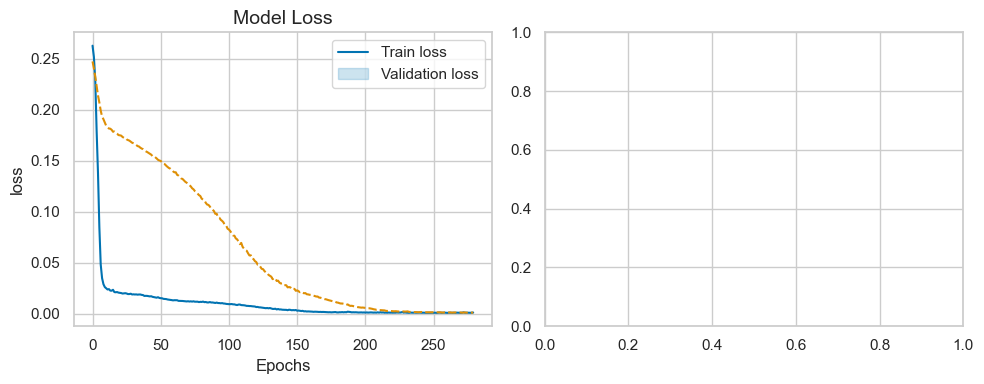

In [767]:
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('loss')
ax[0].legend(['Train loss', 'Validation loss'], loc='upper right')
ax[0].set_title("Model Loss", fontsize=14)

# sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Loss')
# ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
# ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

## Detect Anomalies

After training, we’ll use the trained autoencoder to detect anomalies. When the model fails to reconstruct sequences well (high reconstruction error), it indicates an anomaly.

* Reconstruction Error: We will calculate the error between the actual sensor readings and the reconstructed ones.
* Threshold: We set a threshold for the reconstruction error. Any sequence with an error above this threshold is considered an anomaly.

In [899]:
# Predict reconstruction on normal data
reconstruction = model.predict(X_train)

# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(reconstruction - X_train), axis=1)

# Set a threshold for anomaly detection
anomaly_threshold = np.percentile(reconstruction_error, 99.5)  # Top 5% reconstruction errors
anomalies = reconstruction_error > anomaly_threshold

16/16 [==============================] - 1s 51ms/step


In [901]:
anomaly_threshold

0.08168619230538046

## Evaluate the Model on Test Data

In [903]:
# Scale the entire dataset for evaluation (including abnormal states)
all_data_scaled = scaler.transform(df.drop('state',axis=1).iloc[:, :-1].values)

# Create sequences for evaluation
X_test = create_sequences(all_data_scaled, seq_length)

# Predict and calculate reconstruction error on the test set
reconstruction_test = model.predict(X_test)
reconstruction_error_test = np.mean(np.abs(reconstruction_test - X_test), axis=1)

# Detect anomalies in the test data
anomalies_test = reconstruction_error_test > anomaly_threshold

32/32 [==============================] - 2s 48ms/step


## Visualizing Reconstruction Error and Anomalies

* Reconstruction Error: Plotted for each sequence over time.
* Anomaly Threshold: A red horizontal line indicating the threshold. Any point above this line is considered an anomaly.

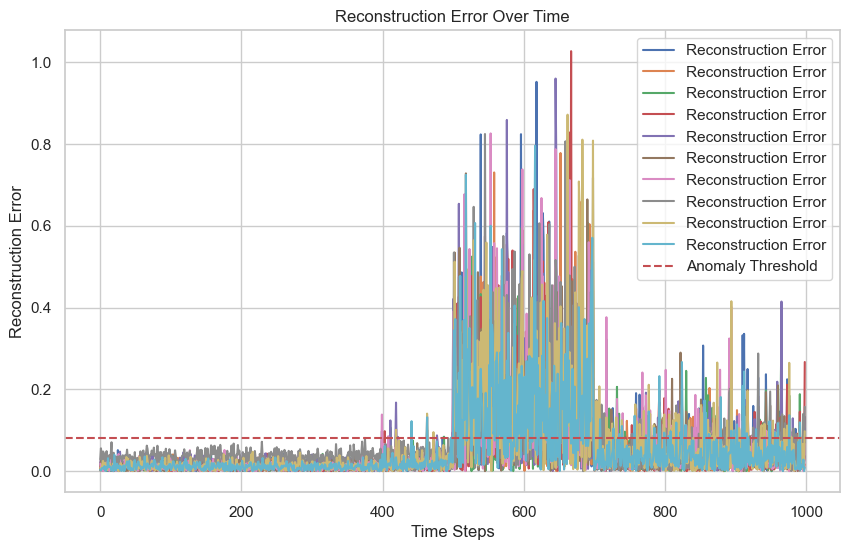

In [905]:
# Plot reconstruction error on test data
plt.figure(figsize=(10,6))
plt.plot(reconstruction_error_test, label='Reconstruction Error')
plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

## Highlighting Anomalies

In [677]:
pd.DataFrame(anomalies_test).shape

(999, 10)

In [679]:
reconstruction_test.shape

(999, 1, 10)

In [907]:
reshaped_reconstruction_test = pd.DataFrame(np.mean(reconstruction_test, axis=1))
reshaped_reconstruction_test.shape

(999, 10)

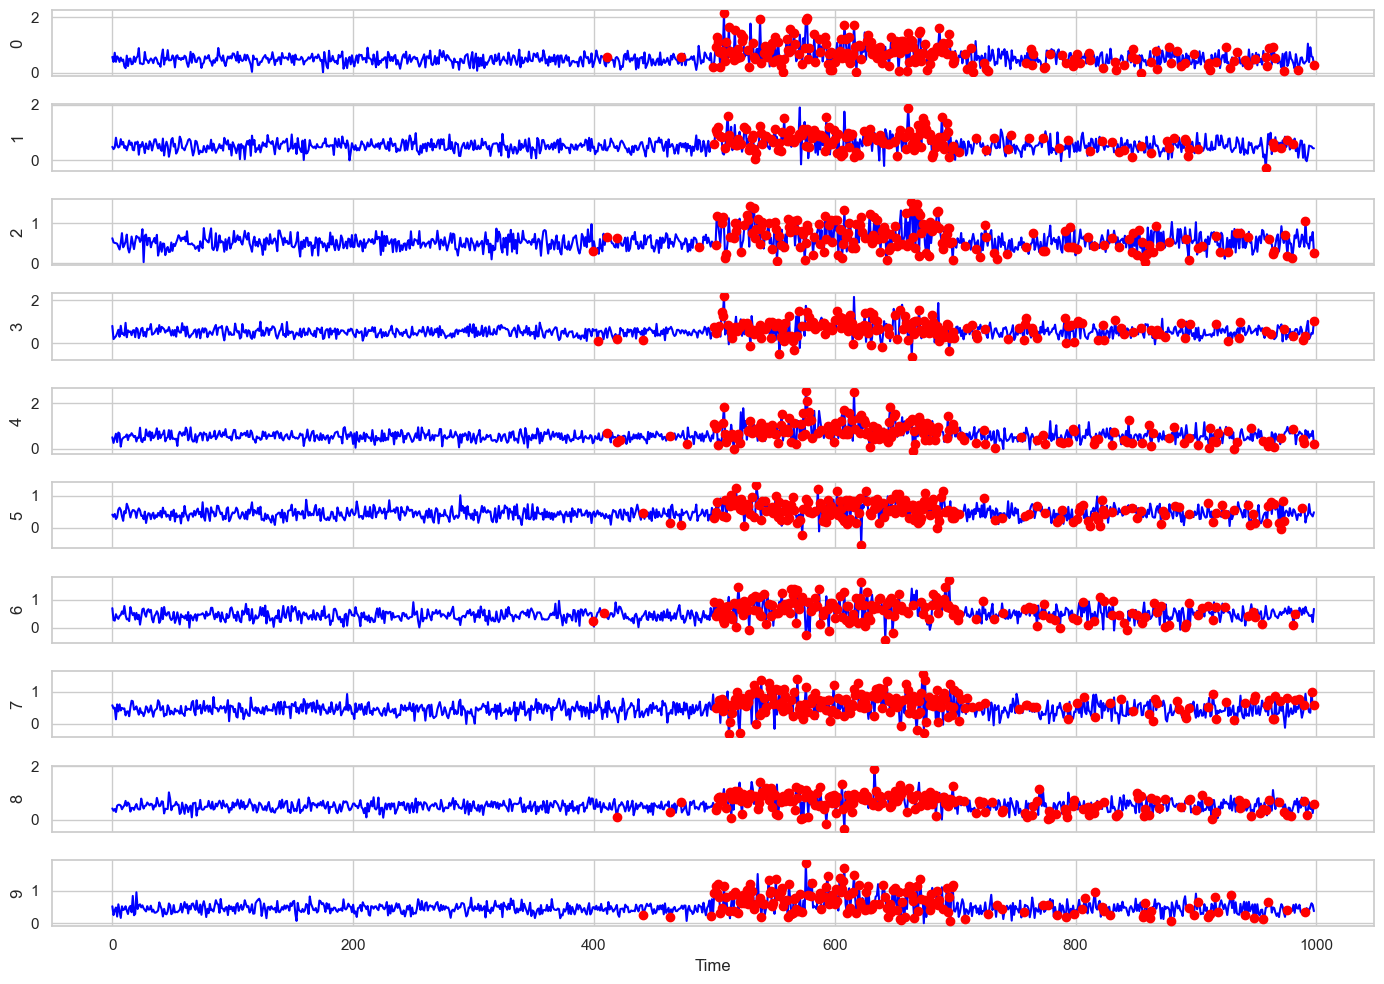

In [909]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_marked_points(timeseries_data: pd.DataFrame, bool_data: pd.DataFrame):
    # Check if both datasets have the same shape
    if timeseries_data.shape != bool_data.shape:
        raise ValueError("Both datasets must have the same shape")

    # Create a figure and subplots
    num_columns = timeseries_data.shape[1]
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, num_columns * 1), sharex=True)
    
    # Plot each column in a separate subplot
    for i, column in enumerate(timeseries_data.columns):
        axs[i].plot(timeseries_data.index, timeseries_data[column], label=column, color='blue')
        
        # Mark points where the boolean data is True
        marked_points = timeseries_data[bool_data[column] == True]
        axs[i].scatter(marked_points.index, marked_points[column], color='red', label='Anomaly', zorder=5)
        
        # Set subplot labels and title
        axs[i].set_ylabel(column)
        # axs[i].legend()
        axs[i].grid(True)
    
    # Set common x-label
    axs[-1].set_xlabel('Time')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


plot_marked_points(reshaped_reconstruction_test, pd.DataFrame(anomalies_test))

In [911]:
# Assuming you have reconstruction_error_test and the threshold applied
y_pred = reconstruction_error_test > anomaly_threshold  # 1 for anomaly, 0 for normal

# Convert boolean array to integers
y_pred = y_pred.astype(int)

In [913]:
y_true = df.state_encoded.map({1:0,0:1,2:0})

In [915]:
seq_length = 1
y_true_trimmed = y_true[seq_length:]

In [917]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
metrics_sensors = pd.DataFrame(columns=['Sensor','Precision', 'Recall', 'F1-score', 'Accuracy'])
for i in range(y_pred.shape[1]):
    precision = precision_score(y_true_trimmed, y_pred[:,i])
    recall = recall_score(y_true_trimmed, y_pred[:,i])
    f1 = f1_score(y_true_trimmed, y_pred[:,i])
    accuracy = accuracy_score(y_true_trimmed, y_pred[:,i])
    metrics_sensors = pd.concat([metrics_sensors, pd.DataFrame({'Sensor': [f'Sensor {i}'], 'Accuracy': [accuracy], 
                                                  'Precision': [precision], 'Recall': [recall], 
                                                  'F1-score': [f1]})], ignore_index=True)

# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"Accuracy: {accuracy}")

In [919]:
metrics_sensors

,Sensor,Precision,Recall,F1-score,Accuracy
0,Sensor 0,0.706161,0.745,0.725061,0.886887
1,Sensor 1,0.8,0.64,0.711111,0.895896
2,Sensor 2,0.692708,0.665,0.678571,0.873874
3,Sensor 3,0.723404,0.68,0.701031,0.883884
4,Sensor 4,0.691489,0.65,0.670103,0.871872
5,Sensor 5,0.717073,0.735,0.725926,0.888889
6,Sensor 6,0.712042,0.68,0.695652,0.880881
7,Sensor 7,0.752427,0.775,0.763547,0.903904
8,Sensor 8,0.657143,0.69,0.673171,0.865866
9,Sensor 9,0.775862,0.675,0.721925,0.895896


## Results

* Precision: Ranges from 65.7% to 80.0%, meaning the model is still good at identifying anomalies with fewer false positives.
* Recall: Improved across the board, ranging from 64.0% to 77.5%, indicating that more true anomalies are being detected.
* F1-Score: Most scores are now around 67-76%, indicating a better balance between precision and recall.
* Accuracy: All sensors have an accuracy of around 86-90%, which reflects the model's overall performance but can be biased by the higher number of normal cases.

# Other Models:

## Isolation forest

Isolation Forest is an unsupervised learning algorithm designed specifically for anomaly detection. It works by randomly partitioning data points and isolating the outliers.

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [20]:
y = df['state_encoded'].values
train_size = int(0.8 * len(df))
X_train, X_test = scaled_sensor_data[:train_size], scaled_sensor_data[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [30]:
from sklearn.ensemble import IsolationForest

y_true = df.state_encoded.map({1:0,0:1,2:0})

X_full = np.concatenate((X_train, X_test), axis=0)  # Combine if needed

# Fit the Isolation Forest on the full dataset
iso_forest_full = IsolationForest(contamination=0.20, random_state=42)
iso_forest_full.fit(X_full)

# Predict anomalies (-1 = anomaly, 1 = normal)
y_pred_full = iso_forest_full.predict(X_full)

# Convert predictions to binary (1 = anomaly, 0 = normal)
y_pred_full = np.where(y_pred_full == -1, 1, 0)

In [32]:
cm = confusion_matrix(y_true, y_pred_full)
precision = precision_score(y_true, y_pred_full)
recall = recall_score(y_true, y_pred_full)
f1 = f1_score(y_true, y_pred_full)
accuracy = accuracy_score(y_true, y_pred_full)

print(f"Confusion Matrix:\n{cm}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Confusion Matrix:
[[786  14]
 [ 14 186]]
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Accuracy: 0.972


### Key Observations:
Precision:

Isolation Forest has higher precision (0.93) compared to the LSTM Autoencoder (best case: 0.80). This indicates fewer false positives with Isolation Forest, meaning it is better at flagging anomalies that are truly anomalies.

Recall:

Isolation Forest also has higher recall (0.93) compared to the LSTM Autoencoder (best case: 0.775). This means it is better at detecting true anomalies, with fewer false negatives.

F1 Score:

Isolation Forest’s F1 score is also much higher at 0.93 compared to the LSTM (best case: 0.763). The F1 score balance suggests that the Isolation Forest model achieves both good precision and recall.

Accuracy:

Isolation Forest achieves higher accuracy (97.2%) compared to the LSTM Autoencoder’s range (best case: 90.4%). This indicates that Isolation Forest is generally better at classifying normal and anomalous data points.

In [34]:
def plot_time_series_with_marker(data, columns_to_plot, marker_column, marker_value, predicted_failure_column=None, predicted_failure_value=1):
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        raise ValueError("The index of the DataFrame must be datetime-like.")
    
    missing_cols = [col for col in columns_to_plot if col not in data.columns]
    if marker_column not in data.columns:
        missing_cols.append(marker_column)
    
    if predicted_failure_column and predicted_failure_column not in data.columns:
        missing_cols.append(predicted_failure_column)
    
    if missing_cols:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_cols}")
    
    num_plots = len(columns_to_plot)
    num_rows = (num_plots + 2) // 1
    
    fig, axes = plt.subplots(num_rows, 1, figsize=(15, 2 * num_rows))
    axes = axes.flatten()
    
    for i, column in enumerate(columns_to_plot):
        sns.lineplot(data=data, x=data.index, y=data[column], ax=axes[i], label=column, color='black')
        
        # Mark the actual machine breakdowns (red 'x')
        marked_points = data[data[marker_column] == marker_value]
        if not marked_points.empty:
            axes[i].scatter(marked_points.index, marked_points[column], color='red', marker='x', label=f'{marker_column} = BROKEN')
        
        # Mark the predicted failures (blue '+')
        if predicted_failure_column:
            predicted_points = data[data[predicted_failure_column] == predicted_failure_value]
            if not predicted_points.empty:
                axes[i].scatter(predicted_points.index, predicted_points[column], color='blue', marker='+', label=f'{predicted_failure_column} = PREDICTED FAILURE')
        
        axes[i].set_title(f'{column} vs Time')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [36]:
df.tail()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state,state_encoded
2023-02-11 11:00:00,2.802049,-0.005869,1.050746,-1.131907,0.754634,0.412640,-0.084759,-0.752637,-0.957045,0.423529,recovery,2
2023-02-11 12:00:00,0.943409,-0.190744,0.430902,-0.056872,0.147789,-0.300667,0.026959,4.047061,0.467451,0.967945,recovery,2
2023-02-11 13:00:00,0.657035,-0.394225,1.940984,-0.436746,1.582582,-0.501310,-1.439959,0.548094,-1.657003,0.803460,recovery,2
2023-02-11 14:00:00,-1.791238,-0.478512,-2.147595,4.236251,-2.480939,0.014721,1.714956,1.554579,1.277013,-0.475843,recovery,2
2023-02-11 15:00:00,2.026633,1.370087,0.318449,0.360871,-0.455884,-1.364478,1.855726,1.968312,-1.326164,-0.230678,recovery,2


In [38]:
df_final = df.copy()
df_final['predicted_failure'] = y_pred_full

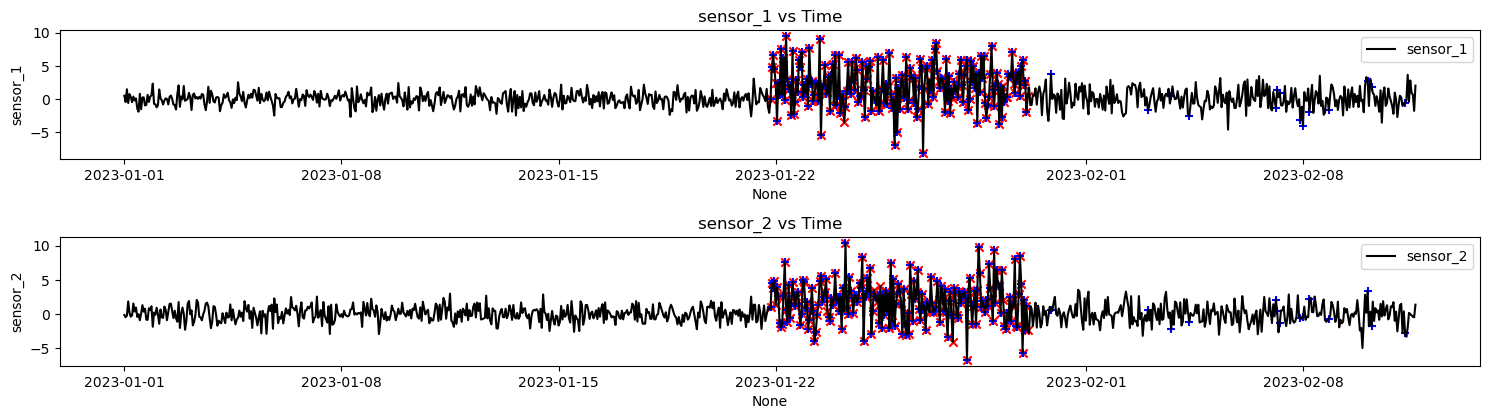

In [42]:
import seaborn as sns

plot_time_series_with_marker(data=df_final, 
                             columns_to_plot=['sensor_1', 'sensor_2'], 
                             marker_column='state', 
                             marker_value='broken', 
                             predicted_failure_column='predicted_failure', 
                             predicted_failure_value=1)

## Real-Time

In [44]:
def predict_failure_in_real_time(new_data_batch, iso_forest_model, window_size=60, failure_threshold=3):
    # Predict anomalies in new incoming data
    scaler = MinMaxScaler(feature_range=(0, 1))
    new_data_batch = scaler.fit_transform(new_data_batch)
    y_pred_real_time = iso_forest_model.predict(new_data_batch)
    y_pred_real_time = np.where(y_pred_real_time == -1, 1, 0)  # 1 = anomaly, 0 = normal
    
    anomaly_count = np.convolve(y_pred_real_time, np.ones(window_size), 'valid')
    failure_prediction = anomaly_count > failure_threshold
    
    if np.any(failure_prediction):
        print("Warning: Potential machine failure detected!")

    return  y_pred_real_time, anomaly_count, failure_prediction

In [46]:
# Simulate a new batch of sensor data (10 features, 100 data points)
new_data_batch = np.random.rand(1000, 10)

In [52]:
# lets create a new data set as unseen data for our model and test it like it is a real-time data.
# in this one I create anoma;ies indicating failures

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 800 + ['broken'] * 200 + ['recovery'] * 0

for i in range(800, 1000):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df_future['state'] = state_labels

df_future.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state
2023-02-11 15:00:00,2.706850,0.628133,0.907969,0.503826,0.651118,-0.319318,-0.848077,0.605965,-2.018168,0.740122,normal
2023-02-11 16:00:00,0.528813,-0.589001,0.188695,-0.758872,-0.933237,0.955057,0.190794,1.978757,2.605967,0.683509,normal
2023-02-11 17:00:00,0.302665,1.693723,-1.706086,-1.159119,-0.134841,0.390528,0.166905,0.184502,0.807706,0.072960,normal
2023-02-11 18:00:00,0.638787,0.329646,-0.497104,-0.754070,-0.943406,0.484752,-0.116773,1.901755,0.238127,1.996652,normal
2023-02-11 19:00:00,-0.993263,0.196800,-1.136645,0.000366,1.025984,-0.156598,-0.031579,0.649826,2.154846,-0.610259,normal


In [54]:
 y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future.drop('state',axis=1), iso_forest_full, window_size=50, failure_threshold=5)

In [88]:
# as expected the model predicts failure on unseen data. There is a trick with a window_size and a treshold,
# we can play with it 

<Axes: xlabel='None', ylabel='sensor_1'>

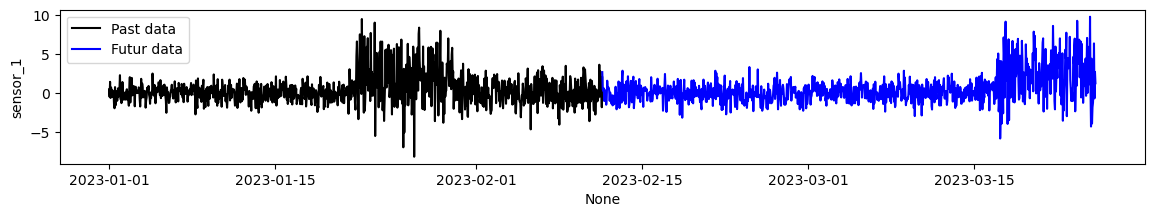

In [56]:
plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

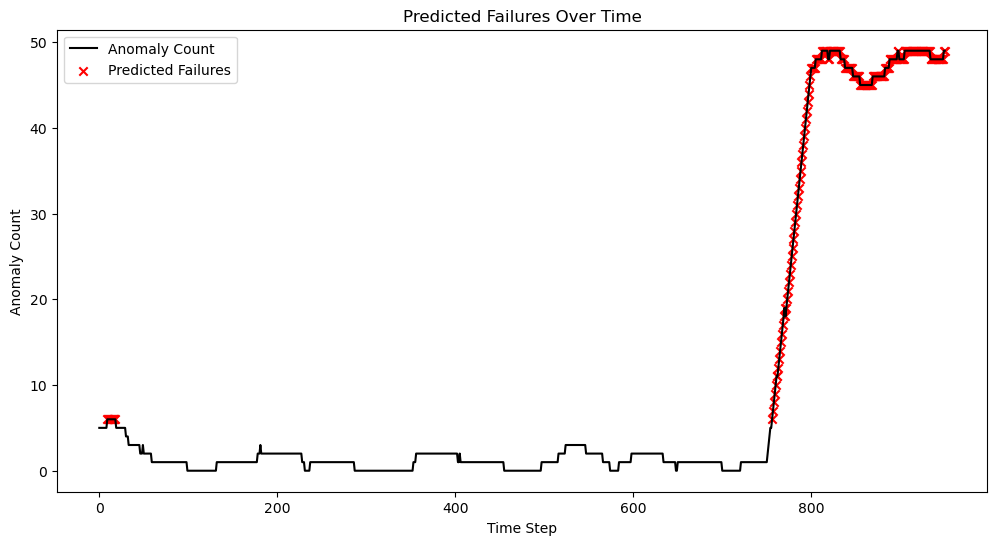

In [58]:
# Visualize the result
plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

In [60]:
# now lets make another dataset with no anomalies, idealy the model should give no warnings

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 1000 + ['broken'] * 0 + ['recovery'] * 0

# for i in range(800, 1000):  # Broken state: (higher variance)
#     sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df_future['state'] = state_labels

df_future.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state
2023-02-11 15:00:00,2.706850,0.628133,0.907969,0.503826,0.651118,-0.319318,-0.848077,0.605965,-2.018168,0.740122,normal
2023-02-11 16:00:00,0.528813,-0.589001,0.188695,-0.758872,-0.933237,0.955057,0.190794,1.978757,2.605967,0.683509,normal
2023-02-11 17:00:00,0.302665,1.693723,-1.706086,-1.159119,-0.134841,0.390528,0.166905,0.184502,0.807706,0.072960,normal
2023-02-11 18:00:00,0.638787,0.329646,-0.497104,-0.754070,-0.943406,0.484752,-0.116773,1.901755,0.238127,1.996652,normal
2023-02-11 19:00:00,-0.993263,0.196800,-1.136645,0.000366,1.025984,-0.156598,-0.031579,0.649826,2.154846,-0.610259,normal


In [64]:
 y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future.drop('state',axis=1), iso_forest_full, window_size=50, failure_threshold=5)

In [68]:
# it gives a warnig for potential failures... lets see

<Axes: xlabel='None', ylabel='sensor_1'>

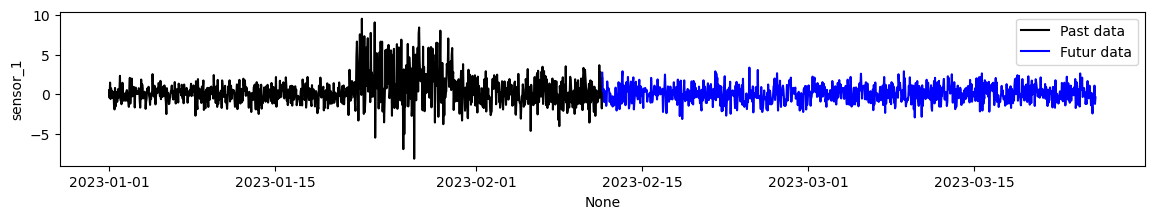

In [66]:
plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

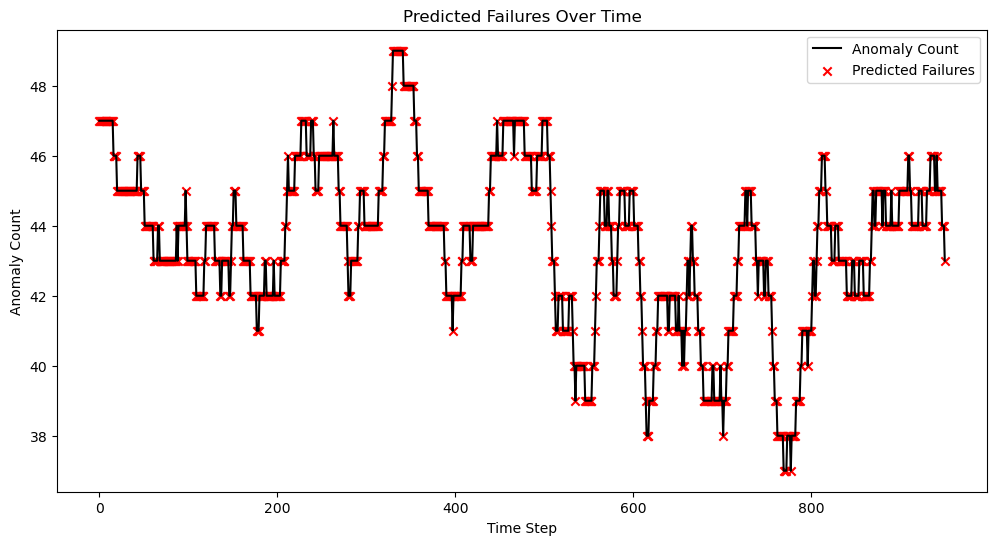

In [70]:
# Visualize the result
plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

In [72]:
# I played with a window size and a treshold...it is not really possible to make it work good for both cases... 
# our model might be too sensitive

In [74]:
# lets make another data set with more then just one banch of anomalies (shorter in time as well)
np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 800 + ['broken'] * 200 + ['recovery'] * 0

for i in range(100, 200):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
for i in range(500, 550):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    

for i in range(800, 950):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df_future['state'] = state_labels

df_future.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state
2023-02-11 15:00:00,2.706850,0.628133,0.907969,0.503826,0.651118,-0.319318,-0.848077,0.605965,-2.018168,0.740122,normal
2023-02-11 16:00:00,0.528813,-0.589001,0.188695,-0.758872,-0.933237,0.955057,0.190794,1.978757,2.605967,0.683509,normal
2023-02-11 17:00:00,0.302665,1.693723,-1.706086,-1.159119,-0.134841,0.390528,0.166905,0.184502,0.807706,0.072960,normal
2023-02-11 18:00:00,0.638787,0.329646,-0.497104,-0.754070,-0.943406,0.484752,-0.116773,1.901755,0.238127,1.996652,normal
2023-02-11 19:00:00,-0.993263,0.196800,-1.136645,0.000366,1.025984,-0.156598,-0.031579,0.649826,2.154846,-0.610259,normal


<Axes: xlabel='None', ylabel='sensor_1'>

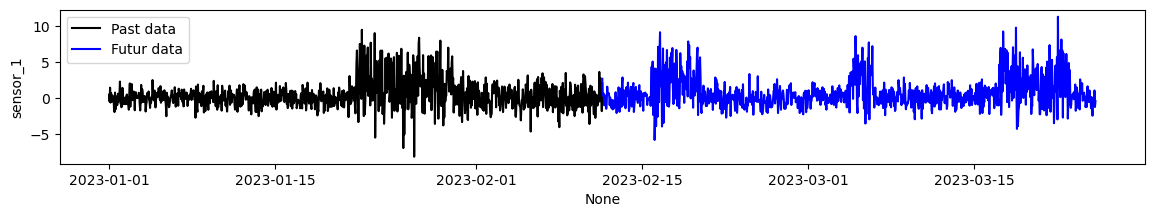

In [76]:
plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

In [84]:
 y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future.drop('state',axis=1), iso_forest_full, window_size=50, failure_threshold=5)

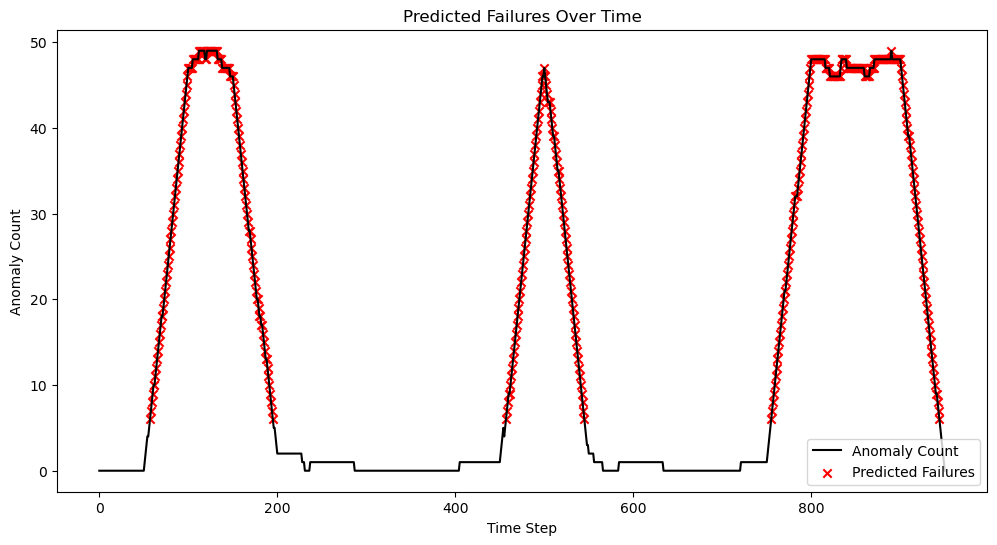

In [86]:
plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

## Model adaptation for real cases

lets decrease the sesibilty of the model. we can do that by changing the contamination parameter. it was 20% and gave us a good statistics but doesnt really work on all types of unseen data. changing contamination parameter may worse the accuracy but better the actual failure prediction. 

In [140]:
iso_forest_full = IsolationForest(contamination=0.05, random_state=42) # 5% /// lets make it less sensitive
iso_forest_full.fit(X_full)

y_pred_full = iso_forest_full.predict(X_full)
y_pred_full = np.where(y_pred_full == -1, 1, 0)

cm = confusion_matrix(y_true, y_pred_full)
precision = precision_score(y_true, y_pred_full)
recall = recall_score(y_true, y_pred_full)
f1 = f1_score(y_true, y_pred_full)
accuracy = accuracy_score(y_true, y_pred_full)

print(f"Confusion Matrix:\n{cm}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Confusion Matrix:
[[800   0]
 [150  50]]
Precision: 1.0
Recall: 0.25
F1 Score: 0.4
Accuracy: 0.85


In [92]:
# as expected the metrics give worse results ... lets see how it goes on unseen data

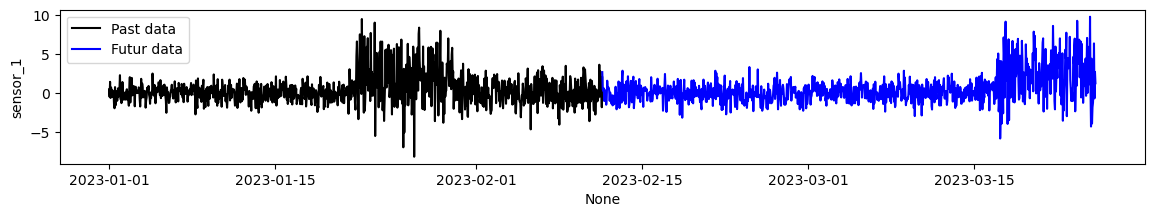

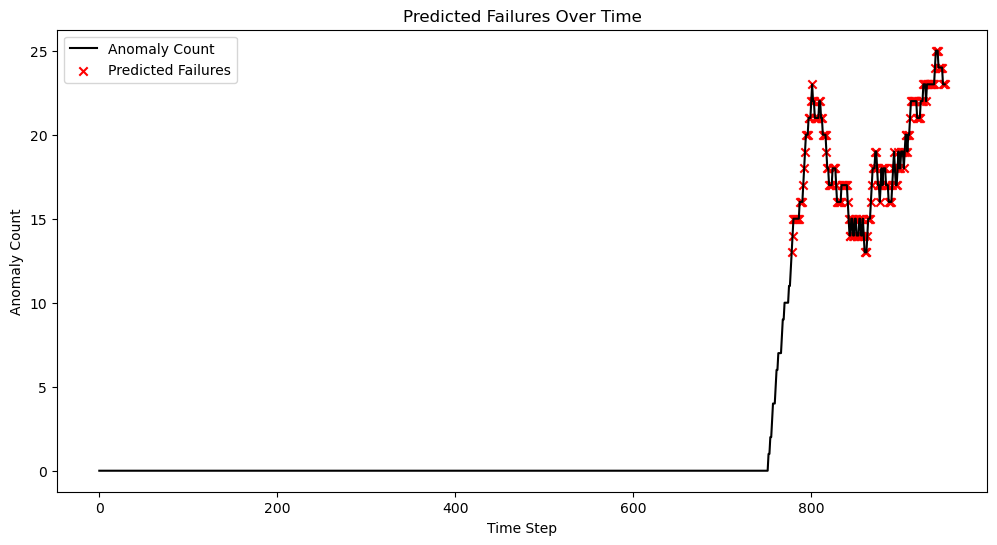

In [146]:
# data with one long period of anomalies

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 800 + ['broken'] * 200 + ['recovery'] * 0

for i in range(800, 1000):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df_future['state'] = state_labels

df_future.head()

y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future.drop('state',axis=1), iso_forest_full, window_size=50, failure_threshold=12)

plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

In [98]:
# it works good and detect the failure correct

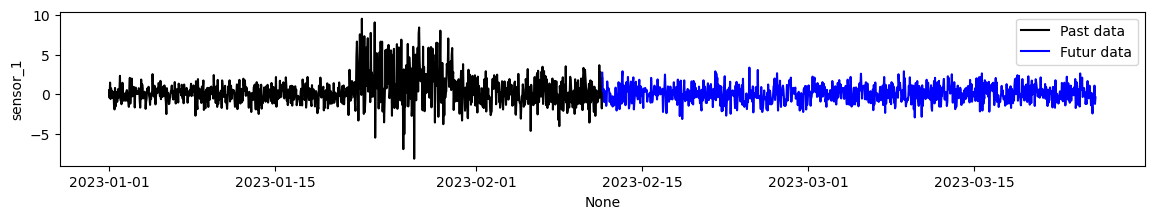

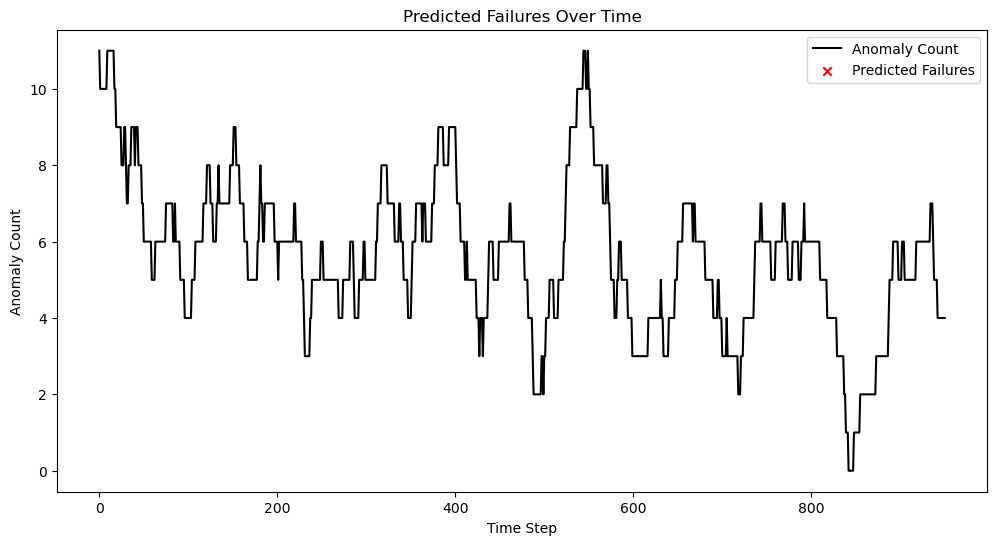

In [174]:
# data with no anomalies

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 1000 + ['broken'] * 0 + ['recovery'] * 0

# for i in range(800, 1000):  # Broken state: (higher variance)
#     sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df_future['state'] = state_labels

df_future.head()

y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future.drop('state',axis=1), iso_forest_full, window_size=50, failure_threshold=12)

plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

In [112]:
# also works good since no potential failures were detected as expected

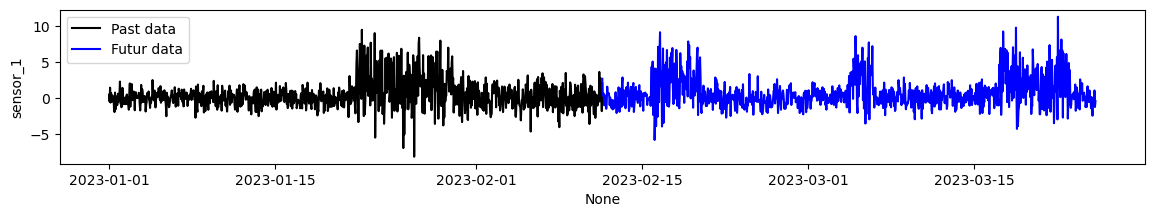

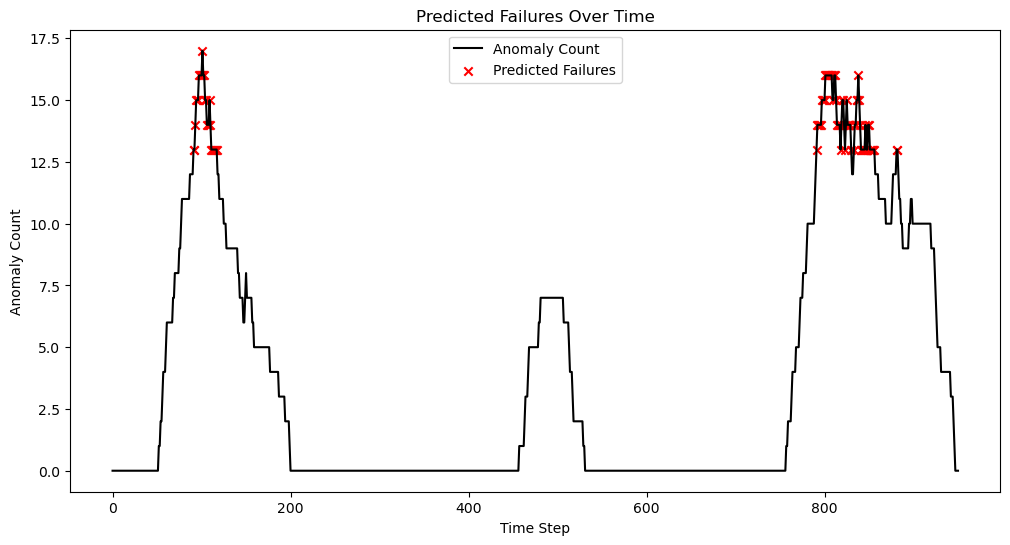

In [176]:
# data with several short in time anomalies

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 800 + ['broken'] * 200 + ['recovery'] * 0

for i in range(100, 200):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
for i in range(500, 550):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    

for i in range(800, 950):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
df_future['state'] = state_labels

df_future.head()

y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future.drop('state',axis=1), iso_forest_full, window_size=50, failure_threshold=12)

plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

In [166]:
# in this case it works for relatively long in time signal for anomalies but doesnt detect short periods.

## Add Moving Averages and derrivative

In [211]:
df.head(2)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,state,state_encoded
2023-01-01 00:00:00,0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,normal,1
2023-01-01 01:00:00,-0.463418,-0.465730,0.241962,-1.91328,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,normal,1


In [378]:
df_train = df.copy()
df_train.drop(['state','state_encoded'],axis=1,inplace=True)

In [380]:
window_size = 5  # Adjust this to control the moving average window size

# df_train.drop('state',axis=1,inplace=True)
# Moving average for each sensor column
for col in df_train.columns:
    df_train[f'{col}_rolling_avg'] = df_train[col].rolling(window=window_size).mean()

# Derivative (rate of change) for each sensor column
for col in df_train.columns:
    df_train[f'{col}_derivative'] = df_train[col].diff()

# Step 2: Handle NaN values (caused by rolling and differencing operations)
df_train.fillna(0, inplace=True)

<Axes: >

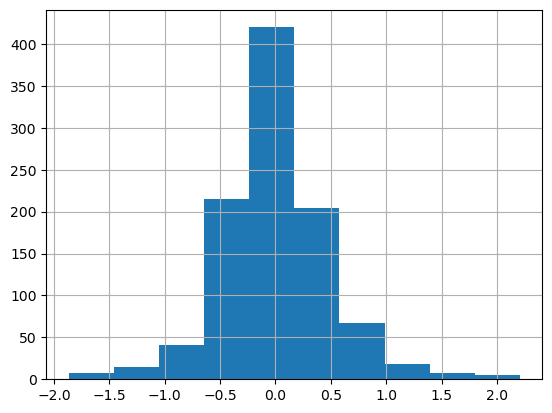

In [382]:
df_train['sensor_1_rolling_avg_derivative'].hist()

In [384]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_train)

In [386]:
iso_forest_full = IsolationForest(contamination=0.05, random_state=42)
iso_forest_full.fit(df_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [388]:
y_pred = iso_forest_full.predict(df_scaled)
y_pred_binary = np.where(y_pred == -1, 1, 0)

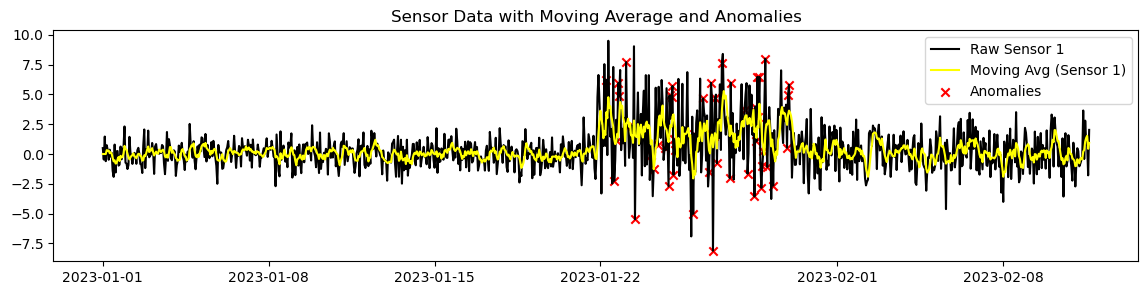

In [390]:
plt.figure(figsize=(14, 3))
plt.plot(df_train.index, df_train['sensor_1'], label='Raw Sensor 1', color='black')
plt.plot(df_train.index, df_train['sensor_1_rolling_avg'], label='Moving Avg (Sensor 1)', color='yellow')

anomaly_indices = np.where(y_pred_binary == 1)[0]  # Get the time steps where failures are predicted
plt.scatter(df_train.iloc[anomaly_indices].index, 
            [y_pred_binary[i] for i in anomaly_indices] * df_train['sensor_1'].iloc[anomaly_indices], 
            color='red', label='Anomalies', marker='x')
# plt.scatter(df_train.index, y_pred_binary * df_train['sensor_1'], color='red', marker='x', label='Anomalies')
plt.title('Sensor Data with Moving Average and Anomalies')
plt.legend()
plt.show()

In [398]:
df_future.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_1_rolling_avg,sensor_2_rolling_avg,sensor_3_rolling_avg,sensor_4_rolling_avg,sensor_5_rolling_avg,sensor_6_rolling_avg,sensor_7_rolling_avg,sensor_8_rolling_avg,sensor_9_rolling_avg,sensor_10_rolling_avg
2023-02-11 15:00:00,2.706850,0.628133,0.907969,0.503826,0.651118,-0.319318,-0.848077,0.605965,-2.018168,0.740122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-11 16:00:00,0.528813,-0.589001,0.188695,-0.758872,-0.933237,0.955057,0.190794,1.978757,2.605967,0.683509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-11 17:00:00,0.302665,1.693723,-1.706086,-1.159119,-0.134841,0.390528,0.166905,0.184502,0.807706,0.072960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-11 18:00:00,0.638787,0.329646,-0.497104,-0.754070,-0.943406,0.484752,-0.116773,1.901755,0.238127,1.996652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-11 19:00:00,-0.993263,0.196800,-1.136645,0.000366,1.025984,-0.156598,-0.031579,0.649826,2.154846,-0.610259,...,0.63677,0.45186,-0.448634,-0.433574,-0.066876,0.270884,-0.127746,1.064161,0.757696,0.576597


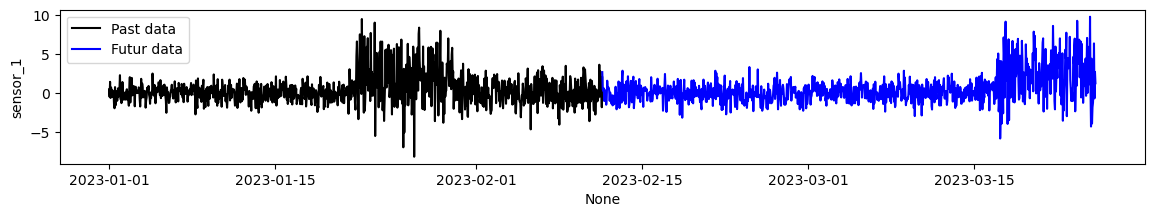

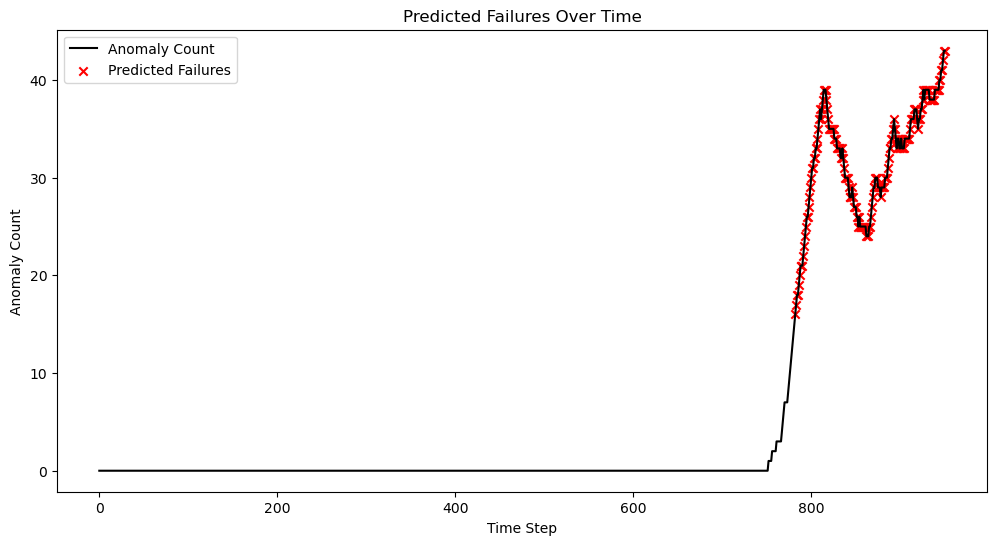

In [422]:
# data with one long period of anomalies

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 800 + ['broken'] * 200 + ['recovery'] * 0

for i in range(800, 1000):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
# df_future['state'] = state_labels

df_future.head()

##############################################################

window_size = 20  # Adjust this to control the moving average window size

for col in df_future.columns:
    df_future[f'{col}_rolling_avg'] = df_future[col].rolling(window=window_size).mean()
for col in df_future.columns:
    df_future[f'{col}_derivative'] = df_future[col].diff()

# Step 2: Handle NaN values (caused by rolling and differencing operations)
df_future.fillna(0, inplace=True)

######################################################################################

y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future, iso_forest_full, window_size=50, failure_threshold=15)

plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

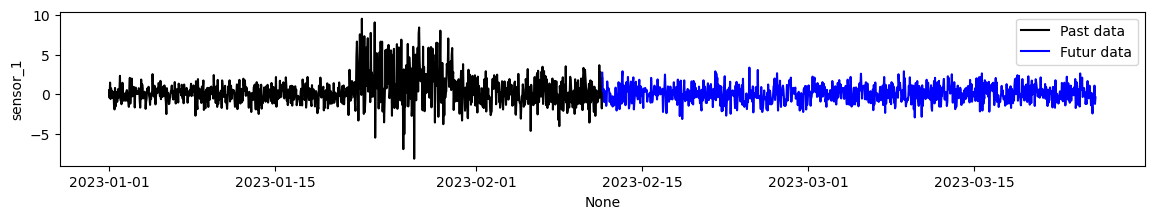

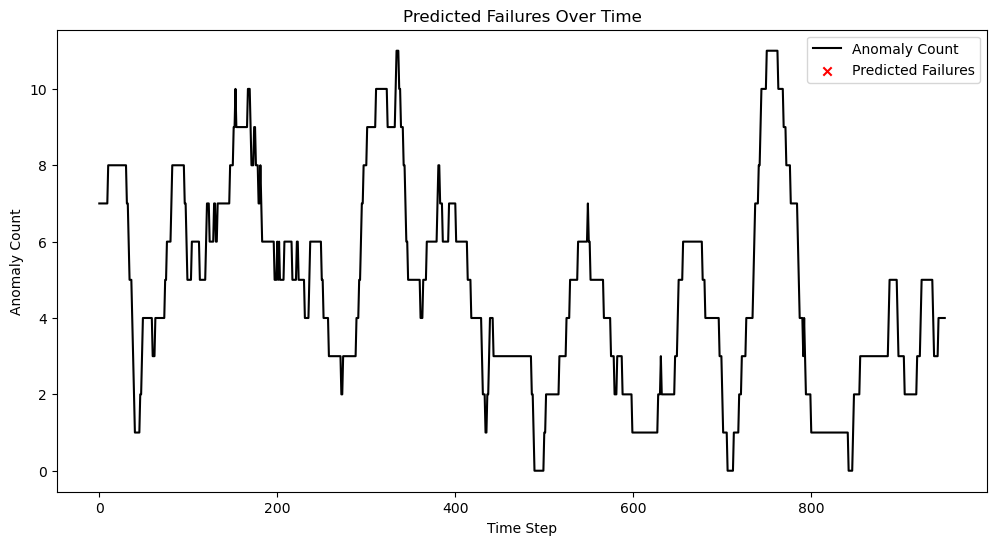

In [418]:
# data with no anomalies

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 1000 + ['broken'] * 0 + ['recovery'] * 0

# for i in range(800, 1000):  # Broken state: (higher variance)
#     sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
# df_future['state'] = state_labels

df_future.head()

##############################################################

window_size = 20  # Adjust this to control the moving average window size

# df_train.drop('state',axis=1,inplace=True)
# Moving average for each sensor column
for col in df_future.columns:
    df_future[f'{col}_rolling_avg'] = df_future[col].rolling(window=window_size).mean()

# Derivative (rate of change) for each sensor column
for col in df_future.columns:
    df_future[f'{col}_derivative'] = df_future[col].diff()

# Step 2: Handle NaN values (caused by rolling and differencing operations)
df_future.fillna(0, inplace=True)

######################################################################################

y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future, iso_forest_full, window_size=50, failure_threshold=15)

plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

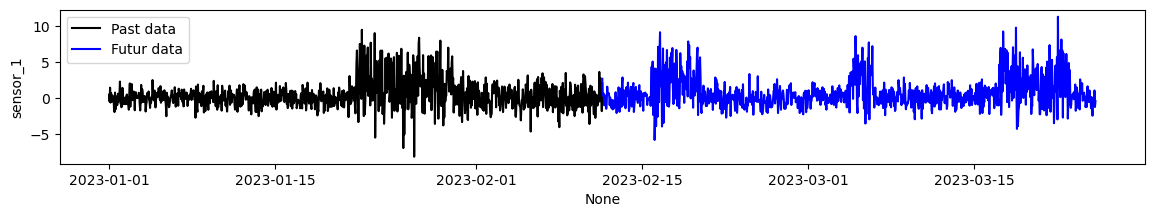

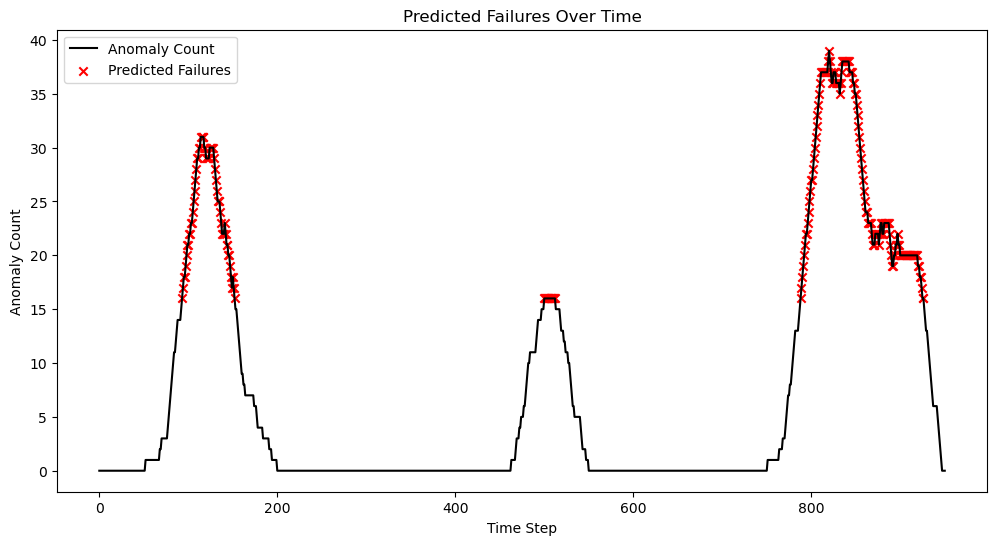

In [416]:
# data with several short in time anomalies

np.random.seed(101)

num_sensors = 10
num_samples = 1000
time_index = pd.date_range(start='2023-02-11 15:00:00', periods=num_samples, freq='H')
sensor_data = np.random.normal(loc=0, scale=1, size=(num_samples, num_sensors))
state_labels = ['normal'] * 800 + ['broken'] * 200 + ['recovery'] * 0

for i in range(100, 200):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
for i in range(500, 550):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    

for i in range(800, 950):  # Broken state: (higher variance)
    sensor_data[i, :] = np.random.normal(loc=2, scale=3, size=num_sensors)
    
# for i in range(900, 1000):  # Recovery state: return to normal
#     sensor_data[i, :] = np.random.normal(loc=0, scale=1.5, size=num_sensors)

columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df_future = pd.DataFrame(sensor_data, columns=columns, index=time_index)
# df_future['state'] = state_labels

df_future.head()

##############################################################

window_size = 20  # Adjust this to control the moving average window size

# df_train.drop('state',axis=1,inplace=True)
# Moving average for each sensor column
for col in df_future.columns:
    df_future[f'{col}_rolling_avg'] = df_future[col].rolling(window=window_size).mean()

# Derivative (rate of change) for each sensor column
for col in df_future.columns:
    df_future[f'{col}_derivative'] = df_future[col].diff()

# Step 2: Handle NaN values (caused by rolling and differencing operations)
df_future.fillna(0, inplace=True)

######################################################################################

y_pred_real_time, anomaly_count, failure_prediction = predict_failure_in_real_time(df_future, iso_forest_full, window_size=50, failure_threshold=15)

plt.figure(figsize=(14,2))
sns.lineplot(data=df_final, x=df_final.index, y=df_final['sensor_1'], color='black',label='Past data')
sns.lineplot(data=df_future, x=df_future.index, y=df_future['sensor_1'], color='blue',label='Futur data')

plt.figure(figsize=(12, 6))

# Plot the rolling anomaly count
plt.plot(anomaly_count, label='Anomaly Count', color='black')

# Mark the points where failures are predicted
failure_indices = np.where(failure_prediction == True)[0]  # Get the time steps where failures are predicted
plt.scatter(failure_indices, anomaly_count[failure_indices], color='red', label='Predicted Failures', marker='x')

plt.title('Predicted Failures Over Time')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Count')
plt.legend()
plt.show()

## Final Results:

now the model predicts all  potential failures!